In [105]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [106]:
data = pd.read_csv("E:\Python\IOT\Train_Test_IoT_Garage_Door.csv")
#ts=date+time所以不需要
data.pop("date")
data.pop("time")
#取代空格
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
"""
data["door_state"] = [i.replace(" ","") for i in data['door_state']]
data["sphone_signal"] = [i.replace(" ","") for i in data['sphone_signal']]"""
#labeling
data['door_state'] = data['door_state'].map({"closed":0,"open":1})
data['sphone_signal'] = data["sphone_signal"].map({"false":0,"true":1,"0":0 ,"1":1})

#ts正規化
# 創建 StandardScaler 物件
scaler = StandardScaler()
data["ts"]=scaler.fit_transform(data["ts"].values.reshape(-1, 1))

#對type進行one hot(因為type有多種類別)
one_hot = pd.get_dummies(data["type"],prefix="type")
data.pop("type")
data = data.join(one_hot)

In [107]:
data.head(10)

,ts,door_state,sphone_signal,label,type_backdoor,type_ddos,type_injection,type_normal,type_password,type_ransomware,type_scanning,type_xss
0,1.096115,0,0,1,False,True,False,False,False,False,False,False
1,1.096120,0,0,1,False,True,False,False,False,False,False,False
2,1.096124,0,0,1,False,True,False,False,False,False,False,False
3,1.096129,0,0,1,False,True,False,False,False,False,False,False
4,1.096138,0,0,1,False,True,False,False,False,False,False,False
5,1.096142,0,0,1,False,True,False,False,False,False,False,False
6,1.096147,0,0,1,False,True,False,False,False,False,False,False
7,1.096152,1,1,1,False,True,False,False,False,False,False,False
8,1.096156,0,0,1,False,True,False,False,False,False,False,False
9,1.096161,0,0,1,False,True,False,False,False,False,False,False


In [108]:
#拿出資料90%當作訓練集
par = np.random.rand(len(data)) < 0.9
data_train = data[par]
#剩下的當作test集
data_test = data[~par]

train_data = data.values
test_data = data.values
#前4列的資料進行訓練
X_train = train_data[:,0:4]
X_train=X_train.astype(float)
#第5列之後為目標變量
Y_train = train_data[:,4:]
Y_train= Y_train.astype(float)
#前4列為測試集
X_test = test_data[:,0:4]
X_test=X_test.astype(float)
#第5列之後為訓練目標變量
Y_test = test_data[:,4:]
Y_test=Y_test.astype(float)

print(Y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(Y_test.dtype)
print(X_test.dtype)

(59587, 8)
(59587, 4)
(59587, 4)
(59587, 8)
float64
float64


In [109]:
#自訂模型
model = Sequential()
#輸入層(4個input)
model.add(Dense(32, input_dim=4, activation="ReLU"))
#隱藏層(ReLU函數)
model.add(Dense(64, activation="ReLU"))
#輸出層(softmax函數)
model.add(Dense(8, activation="softmax"))
#檢測模型狀態 
model.summary()  
# 編譯模型(利用adam優化器)
model.compile(loss="categorical_crossentropy", optimizer="Adam",metrics=["accuracy"])
# 訓練模型
print("Training ...")
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=18, batch_size=200)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                160       
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
Total params: 2,792
Trainable params: 2,792
Non-trainable params: 0
_________________________________________________________________
Training ...
Epoch 1/18
269/269 [==============================] - 1s 2ms/step - loss: 0.9779 - accuracy: 0.6864 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/18
269/269 [==============================] - 0s 1ms/step - loss: 0.6164 - accuracy: 0.8130 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/18
269/269 

In [110]:
# 顯示訓練成果(分數)
loss, accuracy = model.evaluate(X_train, Y_train)
print("訓練資料集的準確度 = {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test)
print("測試資料集的準確度 = {:.2f}".format(accuracy))

1863/1863 [==============================] - 1s 784us/step - loss: 0.0105 - accuracy: 0.9991
訓練資料集的準確度 = 1.00
1863/1863 [==============================] - 2s 812us/step - loss: 0.0105 - accuracy: 0.9991
測試資料集的準確度 = 1.00


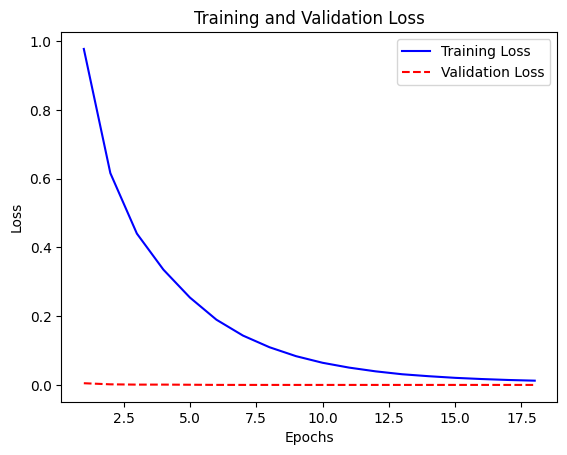

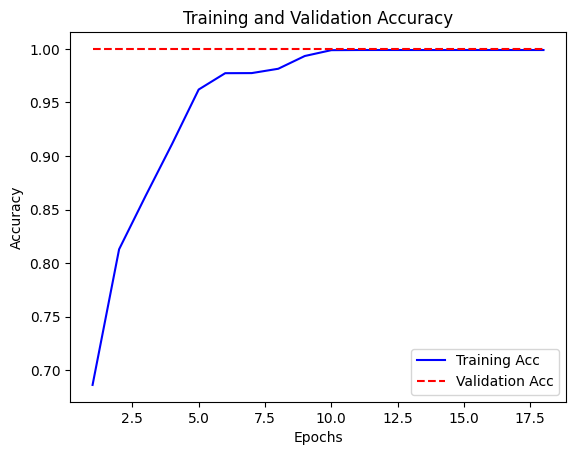

"\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'val'], loc='upper left')\nplt.show() "

In [111]:
# 顯示訓練和驗證損失
loss = history.history["loss"]
epochs = range(1, len(loss)+1)
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["accuracy"]
epochs = range(1, len(acc)+1)
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "b-", label="Training Acc")
plt.plot(epochs, val_acc, "r--", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

"""
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() """


In [112]:
knn_model = KNeighborsClassifier(n_neighbors = 10, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1)

In [113]:
accuracy = cross_val_score(knn_model, X_test, Y_test, cv=10, scoring="accuracy")
print(accuracy)
print(accuracy.mean()*100,'%')
#可以從accuracy串列中，看到有些組是100%，有些組則是大概90%，也就是說如果我們剛好取的是第一組，
#就會誤以為模型準確度(Accuracy)一定是100%，但實際上只是剛好取到這樣的資料組合

[0.90434637 1.         1.         1.         0.91122672 1.
 1.         1.         1.         1.        ]
98.15573082732001 %


In [114]:
# data.to_csv('processed_data.csv', index=False)